<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

fatal: destination path 'DDM-Project-WS24-25' already exists and is not an empty directory.


In [11]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD

# Loading the Data

In [12]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [13]:
gdp_data = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Transforming the data

In [14]:
# def add_zeros(code):
#     if len(code) == 3:
#         return '00' + code
#     elif len(code) == 4:
#         return '0' + code
#     elif len(code) == 1:
#         return '0000' + code
#     return code

In [15]:
# Filling 0 to get same length for all FIPS
# df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
# unique_lengths = df_pattern['FIPS'].apply(len).unique()
# unique_lengths

# df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [16]:
# Merging Occupation Datasets
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head(5)

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [17]:
# Keeping only the necessary columns

# GDP
# count new feature - gdp growth rate
gdp_data['gdp_growth_rate'] = (
    (gdp_data['2022'] - gdp_data['2017']) / gdp_data['2017']
) * 100
df_gdp_filtered = gdp_data.drop(gdp_data[['TableName', 'LineCode', 'Unit', 'Region', '2017', '2018', '2019', '2020', '2021', 'GeoName', 'IndustryClassification', 'Description']], axis=1)
df_gdp_filtered = df_gdp_filtered.rename(columns={'2022': 'current_gdp'})

df_gdp_filtered['FIPS'] = df_gdp_filtered['FIPS'].astype(str)
df_gdp_filtered = df_gdp_filtered[df_gdp_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers --> need it on county level

# Naics Pattern
df_pattern_filtered = df_pattern.drop(columns=['emp_nf', 'qp1_nf', 'qp1', 'ap_nf',
       'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000', 'n1000_1', 'n1000_2', 'n1000_3', 'n1000_4', 'naics_2', 'State_GEOID',	'County_GEOID'])
df_pattern_filtered = df_pattern_filtered.rename(columns={'DESCRIPTION': 'naics_description'})

df_pattern_filtered['FIPS'] = df_pattern_filtered['FIPS'].astype(str)
df_pattern_filtered = df_pattern_filtered[df_pattern_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

# Naics Occupation
df_occupation_filtered = df_occupation.drop(columns=['State_GEOID', 'NAICS_TITLE', 'emp_total_county_naics', 'state_name'])

df_occupation_filtered['FIPS'] = df_occupation_filtered['FIPS'].astype(str)
df_occupation_filtered = df_occupation_filtered[df_occupation_filtered['FIPS'].str.len() == 5] # Filtering for FIPS with 5 numbers

In [18]:
df_gdp_filtered

,FIPS,current_gdp,gdp_growth_rate
11186,10000,7.517259e+07,8.075498
11187,10000,6.772173e+07,8.436174
11188,10000,6.824330e+05,11.593632
11189,10000,6.809000e+03,21.372549
11190,10000,1.014965e+06,-4.362267
...,...,...,...
108047,98000,4.292295e+08,-3.791375
108048,98000,1.903768e+08,13.679183
108049,98000,1.010181e+09,35.247154
108050,98000,6.650949e+08,4.732549


In [19]:
# # Define the relevant NAICS code prefixes as strings
# relevant_naics_prefixes = ['21', '23', '31', '32', '33']  # Sectors for Mining, Construction, Manufacturing

# # Convert relevant prefixes to a tuple for startswith
# relevant_naics_prefixes = tuple(relevant_naics_prefixes)

# # Filter df_gdp_filtered
# df_gdp_filtered = df_gdp_filtered[
#     df_gdp_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_pattern_filtered
# df_pattern_filtered = df_pattern_filtered[
#     df_pattern_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

# # Filter df_occupation_filtered
# df_occupation_filtered = df_occupation_filtered[
#     df_occupation_filtered['naics'].astype(str).str.startswith(relevant_naics_prefixes)
# ]

In [20]:
# Merge the result with df_occupation_filtered on FIPS and naics
df_naics = df_pattern_filtered.merge(
    df_occupation_filtered,
    on=['FIPS', 'naics'],
    how='left',
)

In [21]:
df_naics.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2131,Support Activities for Mining,54,7136,5,49-9041,Industrial Machinery Mechanics,1.672731
1,10001,2131,Support Activities for Mining,54,7136,5,51-4121,"Welders, Cutters, Solderers, and Brazers",0.650311
2,10001,2131,Support Activities for Mining,54,7136,5,49-3042,"Mobile Heavy Equipment Mechanics, Except Engines",0.337553
3,10001,2131,Support Activities for Mining,54,7136,5,49-3031,Bus and Truck Mechanics and Diesel Engine Spec...,0.295242
4,10001,2131,Support Activities for Mining,54,7136,5,49-9071,"Maintenance and Repair Workers, General",0.271479


In [22]:
# Group by 'FIPS' and 'naics', then sum the specified columns
df_naics_agg = df_naics.groupby(['naics', 'naics_description']).agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
}).reset_index()

df_naics_agg.head()

,naics,naics_description,ap,est,emp
0,1133,Logging,14144703,44479,273558
1,2111,Oil and Gas Extraction,160920430,65731,1086954
2,2121,Coal Mining,28820400,5325,338280
3,2122,Metal Ore Mining,47106670,2210,468182
4,2123,Nonmetallic Mineral Mining and Quarrying,88577161,69455,1183116


In [23]:
# Generate random values for each NAICS and assign them to each entry in the group
np.random.seed(1)

random_values = {naics: np.random.randint(0, 11) for naics in df_naics_agg['naics'].unique()}
df_naics_agg['tool_consumption'] = df_naics_agg['naics'].map(random_values)
df_naics_agg.sort_values(by='emp', ascending=False).head(10)

,naics,naics_description,ap,est,emp,tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6
43,3363,Motor Vehicle Parts Manufacturing,1107920522,134988,19280562,1
12,2381,"Foundation, Structure, and Building Exterior C...",1123358347,2190290,18616472,5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7
9,2371,Utility System Construction,988834457,381603,12313454,9


In [24]:
df_gdp_agg = df_gdp_filtered.groupby('FIPS').agg({
    'current_gdp': 'sum',
    'gdp_growth_rate': 'sum'
}).reset_index()
df_gdp_agg.head()

,FIPS,current_gdp,gdp_growth_rate
0,10000,355577213.0,400.226203
1,10001,22652836.0,302.608968
2,10003,243477316.0,228.186597
3,10005,43727204.0,370.162975
4,11000,574989171.0,450.103693


# Ranking the most important industries

In [25]:
df_rank = df_naics_agg.copy()

for column in df_rank.columns[df_rank.columns.get_loc('ap'):]:
    rank_column_name = f'rank_{column}'
    df_rank[rank_column_name] = df_rank[column].rank(method='min', ascending=False).astype(int)

df_rank.sort_values(by='rank_emp').head()

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5
13,2382,Building Equipment Contractors,2471259455,3208151,36373647,2,3,1,3,53
35,3330A1,"3331, 3332, 3334, 3339",1511893370,362952,20220626,3,4,14,4,48
24,3261,Plastics Product Manufacturing,1112538162,281892,19934743,6,6,17,5,33


In [26]:
weights = {
    'rank_tool_consumption': 0.5,
    'rank_emp': 0.2,
    'rank_ap': 0.1,
    'rank_est': 0.2
}

In [27]:
# calculate the weighted sum
df_rank['Weighted_Sum'] = (df_rank['rank_tool_consumption'] * weights['rank_tool_consumption'] +
                          df_rank['rank_emp'] * weights['rank_emp'] +
                          df_rank['rank_ap'] * weights['rank_ap'] +
                          df_rank['rank_est'] * weights['rank_est'])
df_rank = df_rank.sort_values(by='Weighted_Sum', ascending=True)
# imputing 3371, 3372 with actual description
df_rank['naics_description'] = df_rank['naics_description'].str.replace('3371, 3372', 'Furniture and Related Product Manufacturing', regex=False)
df_rank.head(20)

,naics,naics_description,ap,est,emp,tool_consumption,rank_ap,rank_est,rank_emp,rank_tool_consumption,Weighted_Sum
62,5413,"Architectural, Engineering, and Related Services",4056815914,3014994,43360446,9,2,2,2,5,3.5
65,5617,Services to Buildings and Dwellings,641252104,1986470,17649729,9,16,6,8,5,6.9
9,2371,Utility System Construction,988834457,381603,12313454,9,8,13,10,5,7.9
49,3399,Other Miscellaneous Manufacturing,453204190,472189,7837580,10,21,11,19,1,8.6
33,3327,"Machine Shops; Turned Product; and Screw, Nut,...",611343199,636266,10365797,8,18,9,14,17,14.9
44,3364,Aerospace Product and Parts Manufacturing,946714787,35629,9811934,9,9,43,16,5,15.2
67,8111,Automotive Repair and Maintenance,613043765,2579928,14193850,7,17,3,9,23,15.6
37,3335,Metalworking Machinery Manufacturing,235282422,150709,3546341,9,31,23,30,5,16.2
47,3370A1,Furniture and Related Product Manufacturing,385685233,331463,7914077,8,24,15,18,17,17.5
64,5613,Employment Services,17594424274,2575773,316290486,6,1,4,1,33,17.6


In [28]:
top_industries = np.array(df_rank['naics'].iloc[0:40])
top_industries

array(['5413', '5617', '2371', '3399', '3327', '3364', '8111', '3335',
       '3370A1', '5613', '3222', '3119', '8113', '5321', '3261', '2381',
       '2362', '3219', '3262', '3333', '5612', '3328', '3344', '2383',
       '3311', '2111', '2382', '3330A1', '4881', '3314', '2121', '3241',
       '4412', '3345', '3336', '3320A2', '3363', '4861', '2212', '3362'],
      dtype=object)

# Ranking Occupations

# Merging

In [29]:
# top industries according to the ranking ['5413', '5617', '2371', '3399', '3327', '3364', '8111', '3335',
#        '3370A1', '5613']
df_final = df_naics[df_naics['naics'].isin(top_industries)].reset_index(drop=True)
df_final.head()

,FIPS,naics,naics_description,emp,ap,est,OCC_CODE,OCC_TITLE,emp_occupation
0,10001,2212,Natural Gas Distribution,315,45715,3,49-9041,Industrial Machinery Mechanics,7.824787
1,10001,2212,Natural Gas Distribution,315,45715,3,49-9071,"Maintenance and Repair Workers, General",3.434206
2,10001,2212,Natural Gas Distribution,315,45715,3,17-2112,Industrial Engineers,2.832990
3,10001,2212,Natural Gas Distribution,315,45715,3,51-4121,"Welders, Cutters, Solderers, and Brazers",2.642535
4,10001,2212,Natural Gas Distribution,315,45715,3,17-2141,Mechanical Engineers,2.462181


In [30]:
df_final = df_final.groupby('FIPS').agg({
    'ap': 'sum',
    'est': 'sum',
    'emp': 'sum'
})

## add gdp growth (to be implemented)

In [31]:
df_final = df_final.merge(
  df_gdp_agg,
  how='left',
  on='FIPS'
)
df_final.head()

,FIPS,ap,est,emp,current_gdp,gdp_growth_rate
0,10001,7122903,12430,130652,22652836.0,302.608968
1,10003,58348899,51541,867849,243477316.0,228.186597
2,10005,10944329,19421,214024,43727204.0,370.162975
3,10999,11262604,3286,365254,NaN,NaN
4,11001,82116067,41555,1022360,574989171.0,450.103693


# Data Preprocessing

In [32]:
df_final = df_final.copy()

In [33]:
# Impute Missing GDP with 0
df_final['current_gdp'].fillna(0, inplace=True)
df_final['gdp_growth_rate'].fillna(0, inplace=True)
df_final['gdp_growth_rate'].replace([np.inf, -np.inf], 0, inplace=True)

<ipython-input-33-500d746a0ab3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['current_gdp'].fillna(0, inplace=True)
<ipython-input-33-500d746a0ab3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [34]:
# Choosing relevant features
features = ['ap', 'est', 'emp', 'current_gdp', 'gdp_growth_rate']
X = df_final[features]

In [35]:
# Scaling the data to make them comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA

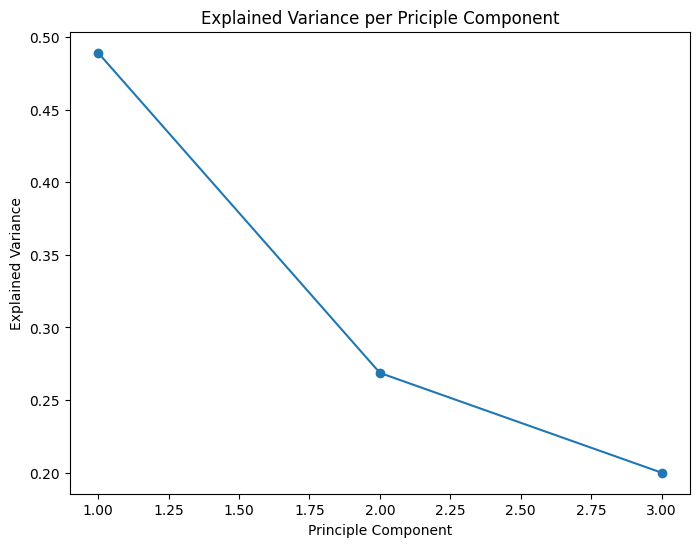

In [36]:
pca = PCA(n_components=3) # the elbow method showed 3 PC are best
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance per Priciple Component')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance')
plt.show()

# Clustering

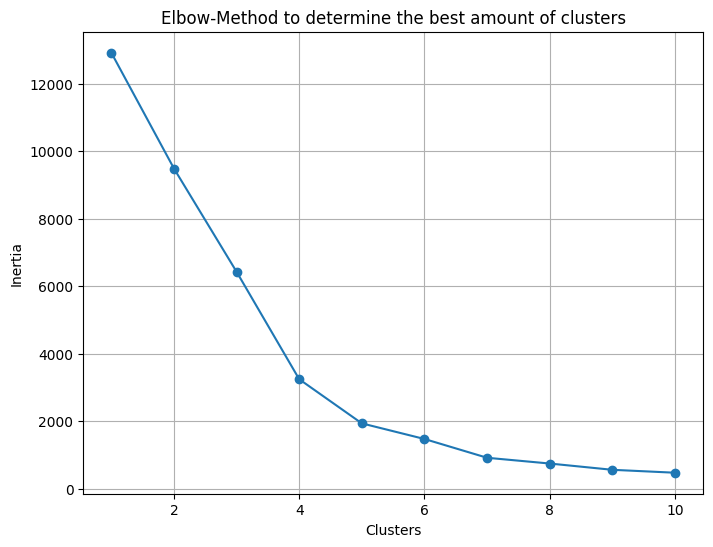

In [37]:
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Elbow-Method to visualize
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow-Method to determine the best amount of clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


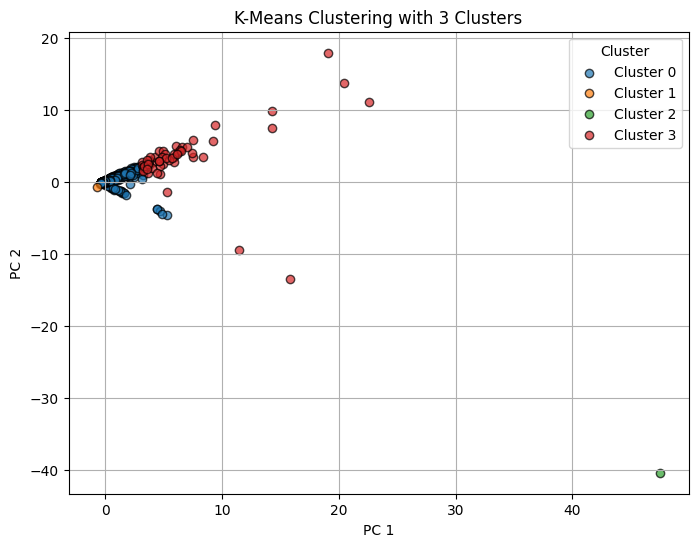

In [38]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)
df_final['cluster'] = clusters

plt.figure(figsize=(8, 6))

for cluster_label in sorted(set(clusters)):
    plt.scatter(
        X_pca[clusters == cluster_label, 0],
        X_pca[clusters == cluster_label, 1],
        label=f'Cluster {cluster_label}',
        alpha=0.7,
        edgecolors='k'
    )

plt.title('K-Means Clustering with 3 Clusters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


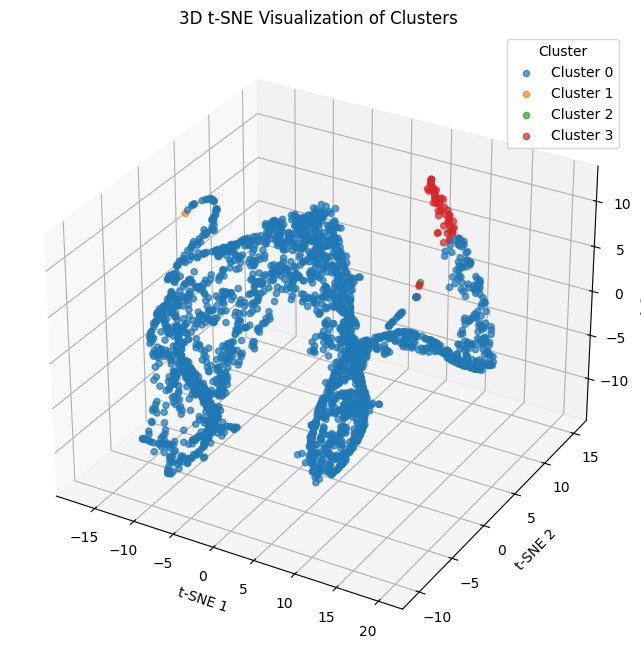

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
X_tsne_3d = tsne_3d.fit_transform(X_pca)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in sorted(set(clusters)):
    ax.scatter(
        X_tsne_3d[clusters == cluster_label, 0],
        X_tsne_3d[clusters == cluster_label, 1],
        X_tsne_3d[clusters == cluster_label, 2],
        label=f'Cluster {cluster_label}',
        alpha=0.7
    )

ax.set_title('3D t-SNE Visualization of Clusters')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

ax.legend(title='Cluster')
plt.show()


# Interpretation

In [40]:
df_final.head()

,FIPS,ap,est,emp,current_gdp,gdp_growth_rate,cluster
0,10001,7122903,12430,130652,22652836.0,302.608968,0
1,10003,58348899,51541,867849,243477316.0,228.186597,0
2,10005,10944329,19421,214024,43727204.0,370.162975,0
3,10999,11262604,3286,365254,0.0,0.000000,0
4,11001,82116067,41555,1022360,574989171.0,450.103693,3


In [41]:
cluster_summary = df_final.groupby('cluster')[['ap', 'est', 'emp', 'current_gdp', 'gdp_growth_rate']].mean().reset_index()
print(cluster_summary)

   cluster            ap            est           emp   current_gdp  \
0        0  7.694390e+06    5789.812144  1.370859e+05  1.569804e+07   
1        1  2.083380e+05     277.000000  3.274000e+03  1.474908e+06   
2        2  4.947763e+09   27497.000000  8.069761e+07  0.000000e+00   
3        3  2.438942e+08  128432.683333  3.358384e+06  5.865739e+08   

   gdp_growth_rate  
0     8.657883e+02  
1     3.023428e+06  
2     0.000000e+00  
3     6.029826e+02  


1.   Cluster 0: Few employment & low GDP
2.   Cluster 1: Highest employement but no GDP.
3.   Cluster 2: Economic top regions with high employment in important industries.


In [42]:
df_result = df_final[(df_final['cluster']==2) | (df_final['cluster']==3)].reset_index(drop=True)
df_result.head()

,FIPS,ap,est,emp,current_gdp,gdp_growth_rate,cluster
0,11001,82116067,41555,1022360,574989171.0,450.103693,3
1,12011,157573963,216746,2677157,588080980.0,497.214801,3
2,12031,108332947,106829,1911641,361484160.0,740.034162,3
3,12057,157696561,158248,2843882,522828093.0,709.372915,3
4,12086,153524610,257186,2915055,870680259.0,471.890006,3


In [43]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FIPS             61 non-null     object 
 1   ap               61 non-null     int64  
 2   est              61 non-null     int64  
 3   emp              61 non-null     int64  
 4   current_gdp      61 non-null     float64
 5   gdp_growth_rate  61 non-null     float64
 6   cluster          61 non-null     int32  
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 3.2+ KB


# Visalization

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Merging GeoData with clusters
gdf_cluster = df_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')
gdf_cluster = gdf_cluster.groupby('FIPS').agg({
    'emp': 'sum',
    'est': 'sum',
    'current_gdp': 'sum'
}).sort_values(['emp',	'est',	'current_gdp'])
gdf_cluster.head()

scaled_values = scaler.fit_transform(gdf_cluster[['emp', 'est', 'current_gdp']])

gdf_cluster['scaled_emp'] = scaled_values[:, 0]
gdf_cluster['scaled_est'] = scaled_values[:, 1]
gdf_cluster['scaled_gdp'] = scaled_values[:, 2]

gdf_cluster['economic_importance'] = (
    gdf_cluster['scaled_emp'] * 0.5 +
    gdf_cluster['scaled_est'] * 0.3 +
    gdf_cluster['scaled_gdp'] * 0.2
)

gdf_cluster = gdf_cluster.sort_values(by='economic_importance', ascending=False)

gdf_cluster.head()

,emp,est,current_gdp,scaled_emp,scaled_est,scaled_gdp,economic_importance
FIPS,,,,,,,
48201,11743389,422616,1.955070e+09,1.000000,0.968536,0.485558,0.887672
17031,8105183,434995,1.998678e+09,0.663767,1.000000,0.497635,0.731410
48113,7532261,243164,1.449368e+09,0.610819,0.512426,0.345504,0.528238
53033,5102035,234622,1.798052e+09,0.386224,0.490715,0.442072,0.428741
36061,3636207,155825,3.812610e+09,0.250756,0.290438,1.000000,0.412510


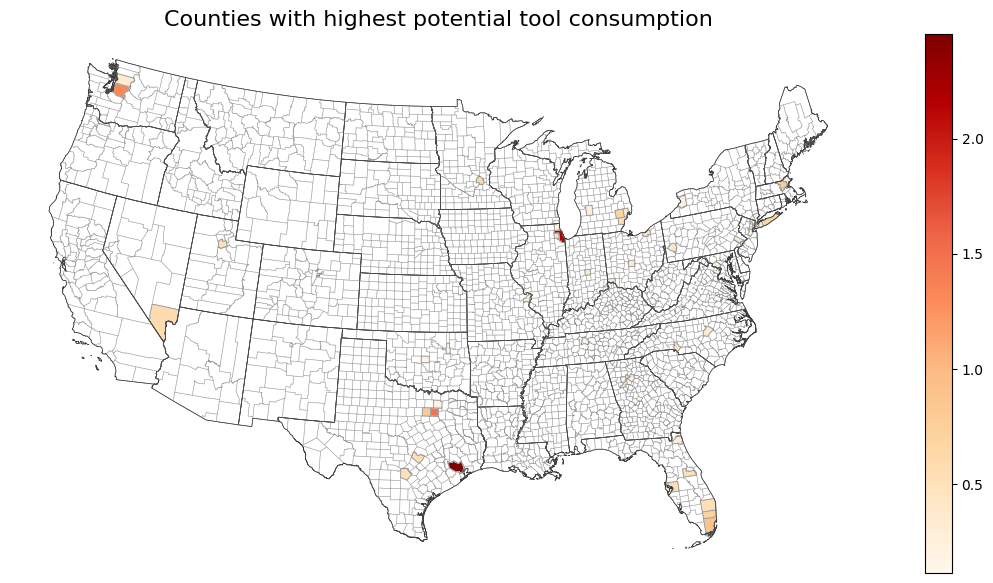

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

scaler = MinMaxScaler()
gdf_cluster['economic_importance'] = scaler.fit_transform(
    gdf_cluster[['emp', 'est', 'current_gdp']]
).sum(axis=1)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['economic_importance'].min()
vmax = gdf_cluster['economic_importance'].max()

gdf_cluster.plot(
    column='economic_importance',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=vmin,
    vmax=vmax
)

filtered_states.boundary.plot(ax=ax, color='black', linewidth=0.5)
filtered_county.boundary.plot(ax=ax, color='gray', linewidth=0.4, alpha=0.5)

ax.set_title('Counties with highest potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()


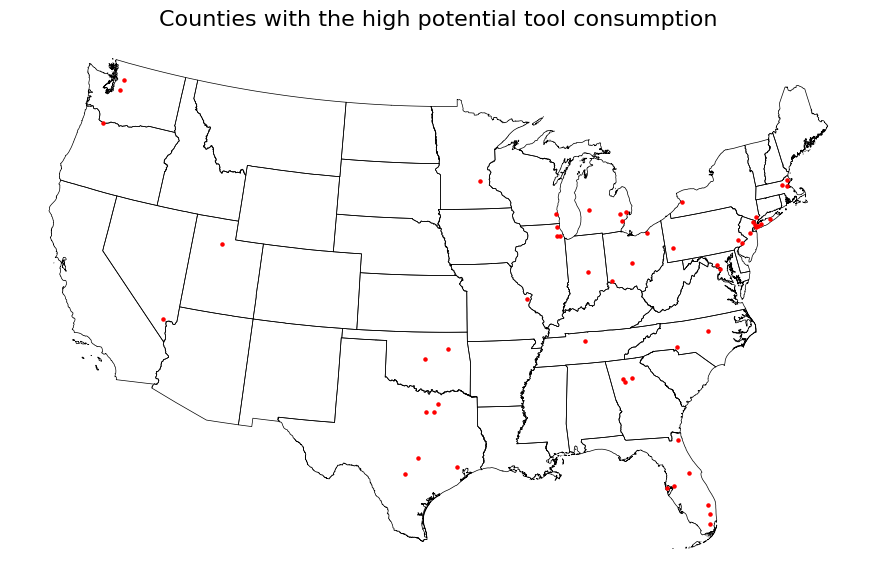

In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

# Exclude some states
non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]

filtered_statefps = filtered_states['STATEFP'].unique()

filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_result, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 7))

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

gdf_cluster.set_geometry('centroid').plot(ax=ax, color='red', markersize=5)

ax.set_title('Counties with the high potential tool consumption', fontsize=16)
ax.set_axis_off()

plt.show()

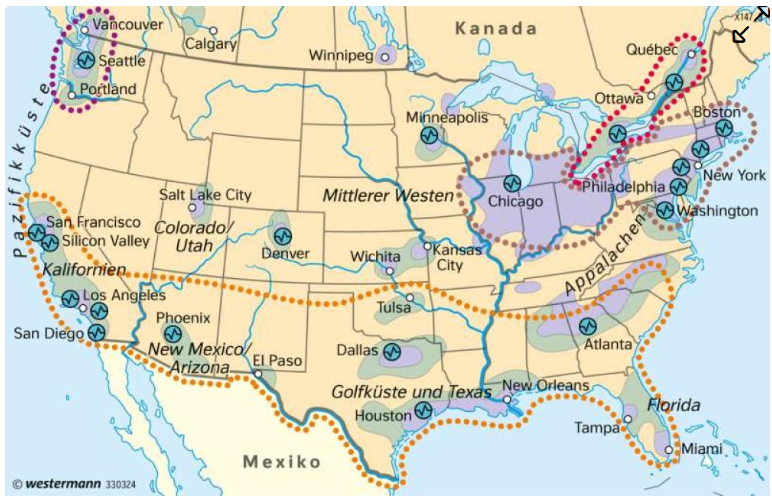

In [47]:
import cv2
from google.colab.patches import cv2_imshow

image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.